# **ALL MODELS - POSTa GAN**

## **Import Dependencies**

In [1]:
# !rm -r /kaggle/working

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Number of devices: 2


In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers as L
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [4]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# **Data Loader**

In [5]:
# DataLoader
train_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/adversarial-gtsrb-data/Adversarial-GTSRB-Data',
    batch_size=128,
    image_size=(81, 81),
    label_mode="categorical",
    labels = "inferred",
    seed=42,
    validation_split=0.2,
    subset='training',
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/adversarial-gtsrb-data/Adversarial-GTSRB-Data',
    batch_size=128,
    image_size=(81, 81),
    label_mode="categorical",
    labels = "inferred",
    seed=42,
    validation_split=0.2,
    subset='validation',
)

Found 211209 files belonging to 43 classes.
Using 168968 files for training.
Found 211209 files belonging to 43 classes.
Using 42241 files for validation.


In [6]:
train_data.as_numpy_iterator().__next__()[0].shape

(128, 81, 81, 3)

In [7]:
train_data.as_numpy_iterator().__next__()[1].shape

(128, 43)

# **Model Prep**

In [8]:
# Create custom F1 Score Metrics

from keras import backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [9]:
steps_per_epoch = len(train_data)
EPOCHS = 128

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=4, min_lr=0.000001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=8,# if val loss decreases for 8 epochs in a row, stop training
                                                  restore_best_weights = True)

# **Model Creations**

In [10]:
# Model

def create_model_1(shape=(81, 81, 3)):
    base_model = EfficientNetV2B0(
        include_top = False,
        input_shape = shape,
        weights = "imagenet",
    )
    
    base_model.trainable = False
#     for layer in base_model.layers[-3:]:
# #         print(layer)
#         layer.trainable = True
        
    x = base_model.output
    x = L.Flatten(name="flatten")(x)
    x = L.Dense(43, activation="softmax", name="Output-layer")(x)
    
    model = tf.keras.models.Model(base_model.input, x, name="EfficientNetV2B0")
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.experimental.SGD(),
        metrics = ["accuracy",tf.keras.metrics.AUC(name="auc"),
                               tf.keras.metrics.Recall(name="recall"),
                               tf.keras.metrics.Precision(name="precision"),
                              f1_score]
    )
    
    return model

In [11]:
# Model

def create_model_2(shape=(81, 81, 3)):
    base_model = EfficientNetB0(
        include_top = False,
        input_shape = shape,
        weights = "imagenet",
    )
    
    base_model.trainable = False
#     for layer in base_model.layers[-3:]:
# #         print(layer)
#         layer.trainable = True
        
    x = base_model.output
    x = L.Flatten(name="flatten")(x)
    x = L.Dense(43, activation="softmax", name="Output-layer")(x)
    
    model = tf.keras.models.Model(base_model.input, x, name="EfficientNetB0")
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.experimental.SGD(),
        metrics = ["accuracy",tf.keras.metrics.AUC(name="auc"),
                               tf.keras.metrics.Recall(name="recall"),
                               tf.keras.metrics.Precision(name="precision"),
                              f1_score]
    )
    
    return model

In [12]:
# Model

def create_model_3(shape=(81, 81, 3)):
    base_model = InceptionV3(
        include_top = False,
        input_shape = shape,
        weights = "imagenet",
    )
    
    base_model.trainable = False
#     for layer in base_model.layers[-3:]:
# #         print(layer)
#         layer.trainable = True
        
    x = base_model.output
    x = L.Flatten(name="flatten")(x)
    x = L.Dense(43, activation="softmax", name="Output-layer")(x)
    
    model = tf.keras.models.Model(base_model.input, x, name="InceptionV3")
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.experimental.SGD(),
        metrics = ["accuracy",tf.keras.metrics.AUC(name="auc"),
                               tf.keras.metrics.Recall(name="recall"),
                               tf.keras.metrics.Precision(name="precision"),
                              f1_score]
    )
    
    return model

In [13]:
# Model

def create_model_4(shape=(81, 81, 3)):
    base_model = ResNet50(
        include_top = False,
        input_shape = shape,
        weights = "imagenet",
    )
    
    base_model.trainable = False
#     for layer in base_model.layers[-3:]:
# #         print(layer)
#         layer.trainable = True
        
    x = base_model.output
    x = L.Flatten(name="flatten")(x)
    x = L.Dense(43, activation="softmax", name="Output-layer")(x)
    
    model = tf.keras.models.Model(base_model.input, x, name="ResNet50")
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.experimental.SGD(),
        metrics = ["accuracy",tf.keras.metrics.AUC(name="auc"),
                               tf.keras.metrics.Recall(name="recall"),
                               tf.keras.metrics.Precision(name="precision"),
                              f1_score]
    )
    
    return model

In [14]:
'''# Model

def create_model_5(shape=(81, 81, 3)):
    base_model = Xception(
        include_top = False,
        input_shape = shape,
        weights = "imagenet",
    )
    
    base_model.trainable = False
    for layer in base_model.layers[-3:]:
#         print(layer)
        layer.trainable = True
        
    x = base_model.output
    x = L.Flatten(name="flatten")(x)
    x = L.Dense(512, activation="relu", name="Dense-1")(x)
    x = L.Dropout(0.4, name="Final-Dropout")(x)
    x = L.Dense(43, activation="softmax", name="Output-layer")(x)
    
    model = tf.keras.models.Model(base_model.input, x, name="Xception")
    model.compile(
        loss="categorical_crossentropy",
        optimizer="Adam",
        metrics = ["accuracy",tf.keras.metrics.AUC(name="auc"),
                               tf.keras.metrics.Recall(name="recall"),
                               tf.keras.metrics.Precision(name="precision"),
                              f1_score]
    )
    
    return model'''

'# Model\n\ndef create_model_5(shape=(81, 81, 3)):\n    base_model = Xception(\n        include_top = False,\n        input_shape = shape,\n        weights = "imagenet",\n    )\n    \n    base_model.trainable = False\n    for layer in base_model.layers[-3:]:\n#         print(layer)\n        layer.trainable = True\n        \n    x = base_model.output\n    x = L.Flatten(name="flatten")(x)\n    x = L.Dense(512, activation="relu", name="Dense-1")(x)\n    x = L.Dropout(0.4, name="Final-Dropout")(x)\n    x = L.Dense(43, activation="softmax", name="Output-layer")(x)\n    \n    model = tf.keras.models.Model(base_model.input, x, name="Xception")\n    model.compile(\n        loss="categorical_crossentropy",\n        optimizer="Adam",\n        metrics = ["accuracy",tf.keras.metrics.AUC(name="auc"),\n                               tf.keras.metrics.Recall(name="recall"),\n                               tf.keras.metrics.Precision(name="precision"),\n                              f1_score]\n    )\n  

In [15]:
# Model

def create_model_6(shape=(81, 81, 3)):
    base_model = MobileNetV2(
        include_top = False,
        input_shape = shape,
        weights = "imagenet",
    )
    
    base_model.trainable = False
#     for layer in base_model.layers[-3:]:
# #         print(layer)
#         layer.trainable = True
        
    x = base_model.output
    x = L.Flatten(name="flatten")(x)
    x = L.Dense(43, activation="softmax", name="Output-layer")(x)
    
    model = tf.keras.models.Model(base_model.input, x, name="MobileNetV2")
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.experimental.SGD(),
        metrics = ["accuracy",tf.keras.metrics.AUC(name="auc"),
                               tf.keras.metrics.Recall(name="recall"),
                               tf.keras.metrics.Precision(name="precision"),
                              f1_score]
    )
    
    return model

# **Train Models**

In [16]:
model_1 = create_model_1()

# Fit the model
history_1 = model_1.fit(
    train_data,
    epochs = EPOCHS,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_data,
    validation_steps = len(val_data),
    callbacks = [reduce_lr],
)

model_1.save("/kaggle/working/EfficientNetV2B0.h5")
pd.DataFrame(history_1.history).to_csv("/kaggle/working/History-EfficientNetV2B0.csv")

24274472/24274472 [==============================] - 0s 0us/step
Epoch 1/128


2024-01-17 13:46:20.499625: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2B0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1321/1321 [==============================] - 420s 310ms/step - loss: 0.9421 - accuracy: 0.7612 - auc: 0.9891 - recall: 0.5560 - precision: 0.9592 - f1_score: 0.6814 - val_loss: 0.6353 - val_accuracy: 0.7960 - val_auc: 0.9946 - val_recall: 0.6997 - val_precision: 0.8825 - val_f1_score: 0.7808 - lr: 0.0100
Epoch 2/128
1321/1321 [==============================] - 110s 83ms/step - loss: 0.4726 - accuracy: 0.8819 - auc: 0.9976 - recall: 0.7776 - precision: 0.9658 - f1_score: 0.8610 - val_loss: 0.3616 - val_accuracy: 0.9094 - val_auc: 0.9984 - val_recall: 0.8371 - val_precision: 0.9704 - val_f1_score: 0.8988 - lr: 0.0100
Epoch 3/128
1321/1321 [==============================] - 69s 52ms/step - loss: 0.3686 - accuracy: 0.9085 - auc: 0.9985 - recall: 0.8311 - precision: 0.9702 - f1_score: 0.8950 - val_loss: 0.3172 - val_accuracy: 0.9165 - val_auc: 0.9985 - val_recall: 0.8582 - val_precision: 0.9657 - val_f1_score: 0.9088 - lr: 0.0100
Epoch 4/128
1321/1321 [==============================] - 63s 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
model_2 = create_model_2()

# Fit the model
history_2 = model_2.fit(
    train_data,
    epochs = EPOCHS,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_data,
    validation_steps = len(val_data),
    callbacks = [reduce_lr],
)

model_2.save("/kaggle/working/EfficientNetB0.h5")
pd.DataFrame(history_2.history).to_csv("/kaggle/working/History-EfficientNetB0.csv")

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/128


2024-01-17 16:15:03.150610: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetB0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1321/1321 [==============================] - 82s 57ms/step - loss: 1.2743 - accuracy: 0.6686 - auc: 0.9791 - recall: 0.4087 - precision: 0.9482 - f1_score: 0.5510 - val_loss: 0.8362 - val_accuracy: 0.7688 - val_auc: 0.9911 - val_recall: 0.5991 - val_precision: 0.9420 - val_f1_score: 0.7324 - lr: 0.0100
Epoch 2/128
1321/1321 [==============================] - 73s 55ms/step - loss: 0.7461 - accuracy: 0.8062 - auc: 0.9935 - recall: 0.6342 - precision: 0.9530 - f1_score: 0.7605 - val_loss: 0.6318 - val_accuracy: 0.8281 - val_auc: 0.9950 - val_recall: 0.6963 - val_precision: 0.9399 - val_f1_score: 0.8000 - lr: 0.0100
Epoch 3/128
1321/1321 [==============================] - 73s 55ms/step - loss: 0.6068 - accuracy: 0.8434 - auc: 0.9956 - recall: 0.7065 - precision: 0.9564 - f1_score: 0.8120 - val_loss: 0.5248 - val_accuracy: 0.8617 - val_auc: 0.9965 - val_recall: 0.7513 - val_precision: 0.9588 - val_f1_score: 0.8425 - lr: 0.0100
Epoch 4/128
1321/1321 [==============================] - 73s 55m

In [18]:
model_3 = create_model_3()

# Fit the model
history_3 = model_3.fit(
    train_data,
    epochs = EPOCHS,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_data,
    validation_steps = len(val_data),
    callbacks = [reduce_lr],
)

model_3.save("/kaggle/working/InceptionV3.h5")
pd.DataFrame(history_3.history).to_csv("/kaggle/working/History-InceptionV3.csv")

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/128
1321/1321 [==============================] - 66s 45ms/step - loss: 8143.9810 - accuracy: 0.0962 - auc: 0.5375 - recall: 0.0962 - precision: 0.0962 - f1_score: 0.0963 - val_loss: 9905.3174 - val_accuracy: 0.0269 - val_auc: 0.5019 - val_recall: 0.0269 - val_precision: 0.0269 - val_f1_score: 0.0268 - lr: 0.0100
Epoch 2/128
1321/1321 [==============================] - 56s 42ms/step - loss: 4810.6636 - accuracy: 0.1675 - auc: 0.5742 - recall: 0.1675 - precision: 0.1675 - f1_score: 0.1677 - val_loss: 13747.4775 - val_accuracy: 0.0258 - val_auc: 0.5013 - val_recall: 0.0258 - val_precision: 0.0258 - val_f1_score: 0.0257 - lr: 0.0100
Epoch 3/128
1321/1321 [==============================] - 59s 45ms/step - loss: 3784.3572 - accuracy: 0.2086 - auc: 0.5953 - recall: 0.2086 - precision: 0.2086 - f1_score: 0.2086 - val_loss: 9392.1348 - val_accuracy: 0.0456 - val_auc: 0.5114 - val_recall: 0.0456 - val_precision: 0.0456 - va

In [19]:
model_4 = create_model_4()

# Fit the model
history_4 = model_4.fit(
    train_data,
    epochs = EPOCHS,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_data,
    validation_steps = len(val_data),
    callbacks = [reduce_lr],
)

model_4.save("/kaggle/working/ResNet50.h5")
pd.DataFrame(history_4.history).to_csv("/kaggle/working/History-ResNet50.csv")

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/128
1321/1321 [==============================] - 127s 92ms/step - loss: 1.1946 - accuracy: 0.7521 - auc: 0.9634 - recall: 0.6967 - precision: 0.8332 - f1_score: 0.7527 - val_loss: 0.4236 - val_accuracy: 0.8761 - val_auc: 0.9943 - val_recall: 0.8337 - val_precision: 0.9241 - val_f1_score: 0.8768 - lr: 0.0100
Epoch 2/128
1321/1321 [==============================] - 120s 90ms/step - loss: 0.3175 - accuracy: 0.9111 - auc: 0.9964 - recall: 0.8758 - precision: 0.9469 - f1_score: 0.9098 - val_loss: 1.9793 - val_accuracy: 0.6259 - val_auc: 0.9221 - val_recall: 0.6087 - val_precision: 0.6353 - val_f1_score: 0.6198 - lr: 0.0100
Epoch 3/128
1321/1321 [==============================] - 120s 90ms/step - loss: 0.2239 - accuracy: 0.9386 - auc: 0.9983 - recall: 0.9129 - precision: 0.9642 - f1_score: 0.9377 - val_loss: 1.1501 - val_accuracy: 0.7505 - val_auc: 0.9575 - val_recall: 0.7346 - val_precision: 0.7633 - val_f1_score: 0.74

In [20]:
# model_5 = create_model_5()

# # Fit the model
# history_5 = model_5.fit(
#     train_data,
#     epochs = EPOCHS,
#     steps_per_epoch = steps_per_epoch,
#     validation_data = val_data,
#     validation_steps = len(val_data),
#     callbacks = [reduce_lr],
# )

# model_5.save("/kaggle/working/Xception.h5")
# pd.DataFrame(history_5.history).to_csv("/kaggle/working/History-Xception.csv")

In [16]:
model_6 = create_model_6()

# Fit the model
history_6 = model_6.fit(
    train_data,
    epochs = EPOCHS,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_data,
    validation_steps = len(val_data),
    callbacks = [reduce_lr],
)

model_6.save("/kaggle/working/MobileNetV2.h5")
pd.DataFrame(history_6.history).to_csv("/kaggle/working/History-MobileNetV2.csv")

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/128
1321/1321 [==============================] - 317s 235ms/step - loss: 19.4746 - accuracy: 0.2477 - auc: 0.6745 - recall: 0.2402 - precision: 0.2598 - f1_score: 0.2499 - val_loss: 73.5882 - val_accuracy: 0.0268 - val_auc: 0.5019 - val_recall: 0.0268 - val_precision: 0.0268 - val_f1_score: 0.0267 - lr: 0.0100
Epoch 2/128
1321/1321 [==============================] - 88s 67ms/step - loss: 9.5389 - accuracy: 0.3885 - auc: 0.7668 - recall: 0.3785 - precision: 0.4076 - f1_score: 0.3929 - val_loss: 27.4102 - val_accuracy: 0.0910 - val_auc: 0.5567 - val_recall: 0.0900 - val_precision: 0.0906 - val_f1_score: 0.0900 - lr: 0.0100
Epoch 3/128
1321/1321 [==============================] - 60s 45ms/step - loss: 7.6187 - accuracy: 0.4474 - auc: 0.8009 - recall: 0.4376 - precision: 0.4690 - f1_score: 0.4528 - val_loss: 30.9860 - val_accuracy: 0.0692 - val_auc: 0.5324 - val_recall: 0.0689 - val_precision: 0.0691 - val_f1_score: 0.0

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Results**

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.saving import load_model

class_names = ['Ahead only', 'Beware of icesnow', 'Bicycles crossing', 'Bumpy road', 'Children crossing', 'Dangerous curve left', 'Dangerous curve right', 'Double curve', 'End no passing veh _ 3.5 tons', 'End of no passing', 'End of speed limit (80kmh)', 'End speed + passing limits', 'General caution', 'Go straight or left', 'Go straight or right', 'Keep left', 'Keep right', 'No entry', 'No passing', 'No passing veh over 3.5 tons', 'No vehicles', 'Pedestrians', 'Priority road', 'Right-of-way at intersection', 'Road narrows on the right', 'Road work', 'Roundabout mandatory', 'Slippery road', 'Speed limit (100kmh)', 'Speed limit (120kmh)', 'Speed limit (20kmh)', 'Speed limit (30kmh)', 'Speed limit (50kmh)', 'Speed limit (60kmh)', 'Speed limit (70kmh)', 'Speed limit (80kmh)', 'Stop', 'Traffic signals', 'Turn left ahead', 'Turn right ahead', 'Veh _ 3.5 tons prohibited', 'Wild animals crossing', 'Yield']

# **EfficientNetV2B0**

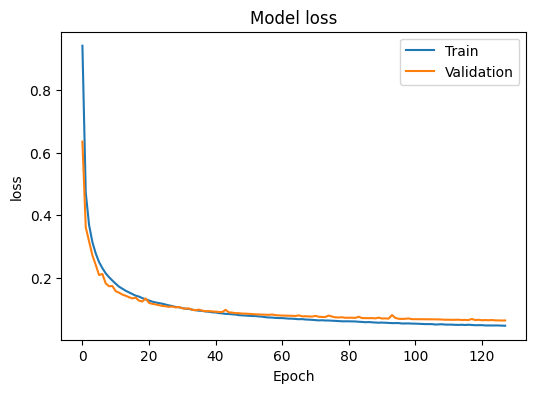

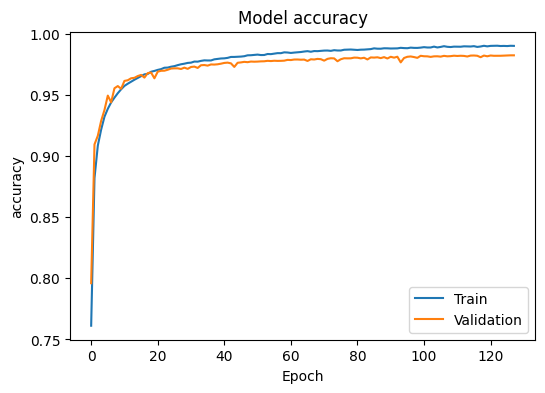

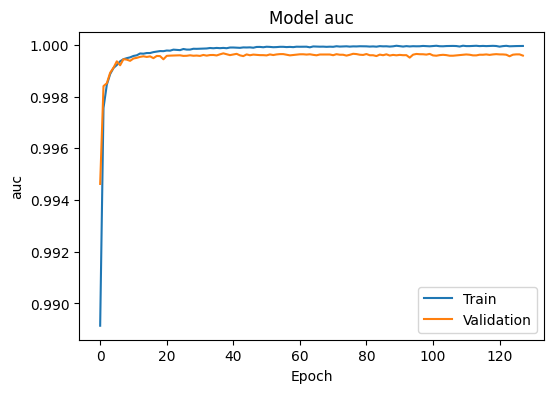

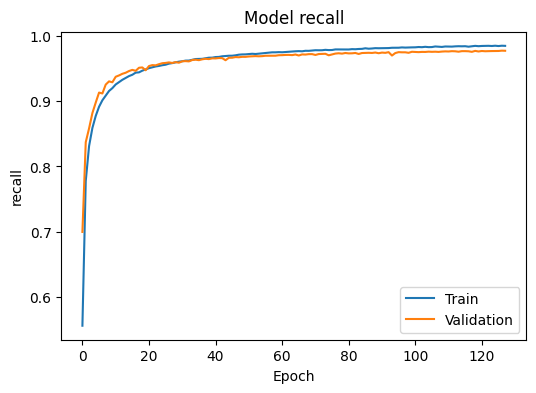

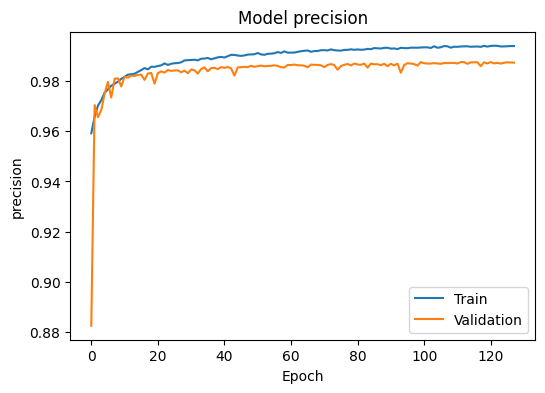

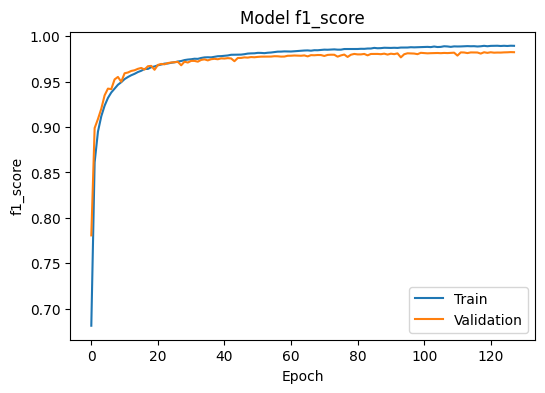

In [23]:
metrics = list(history_1.history.keys())

for metric in metrics:
    if metric.startswith('val')==False and metric!='lr':
        plt.figure(figsize=(6, 4))
        plt.plot(history_1.history[metric])
        plt.plot(history_1.history['val_'+metric])
        plt.title('Model '+metric)
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        if metric.endswith('loss'):
            plt.legend(['Train', 'Validation'], loc='upper right')
        else:
            plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

# **EfficientNetB0**

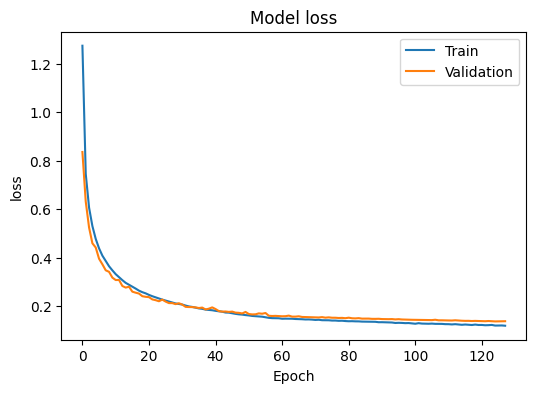

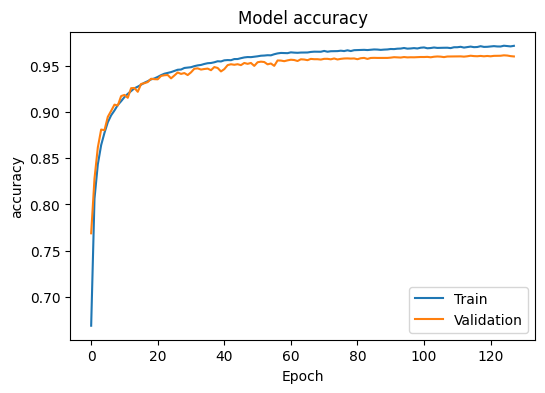

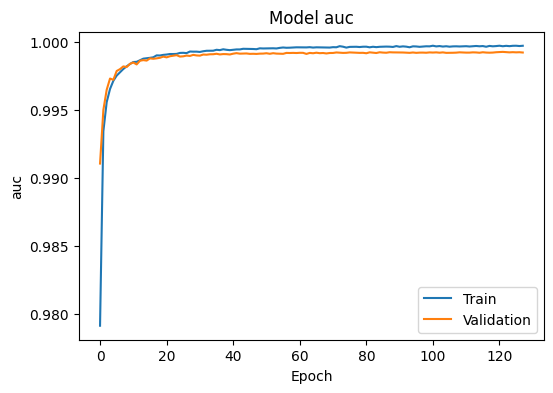

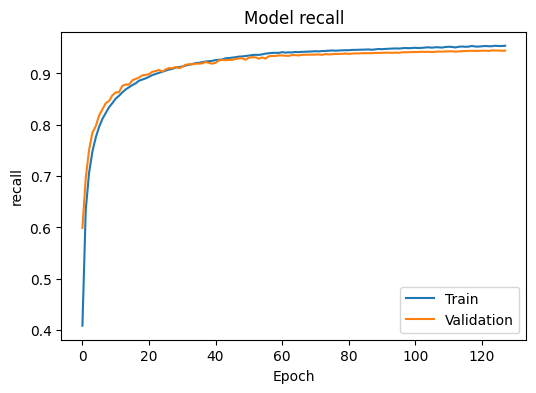

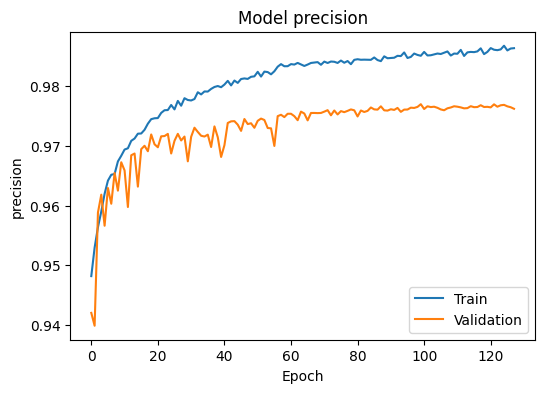

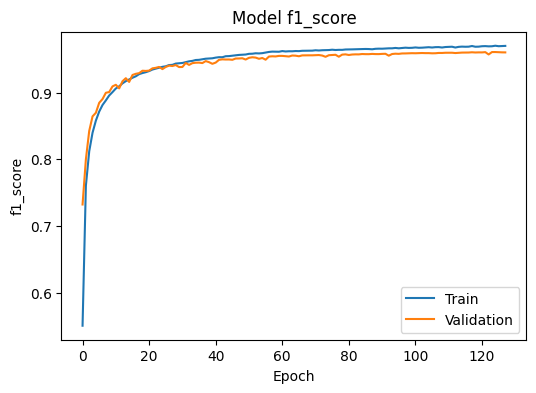

In [24]:
metrics = list(history_2.history.keys())

for metric in metrics:
    if metric.startswith('val')==False and metric!='lr':
        plt.figure(figsize=(6, 4))
        plt.plot(history_2.history[metric])
        plt.plot(history_2.history['val_'+metric])
        plt.title('Model '+metric)
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        if metric.endswith('loss'):
            plt.legend(['Train', 'Validation'], loc='upper right')
        else:
            plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

# **InceptionV3**

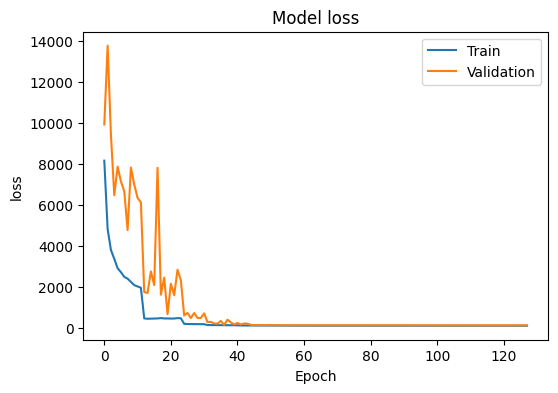

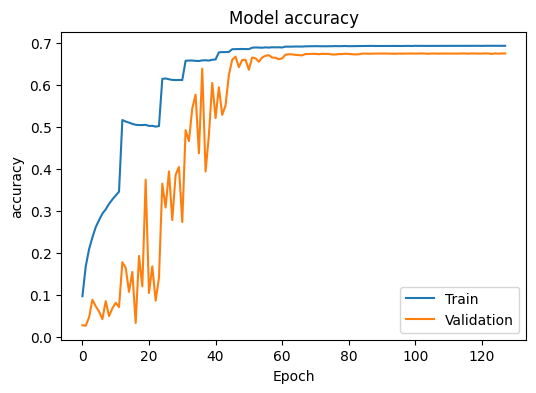

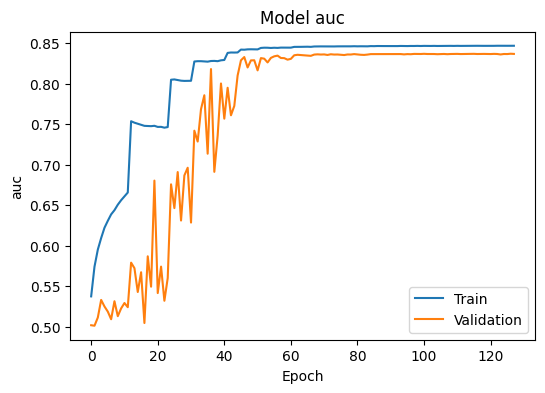

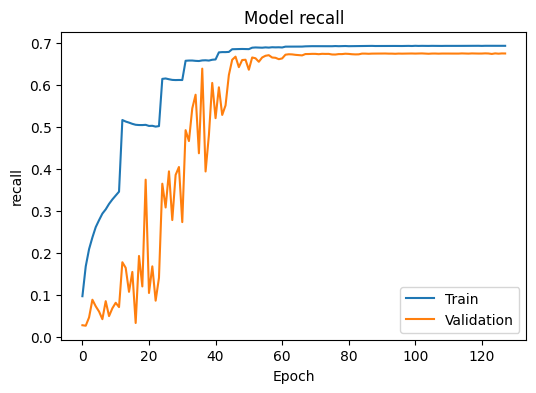

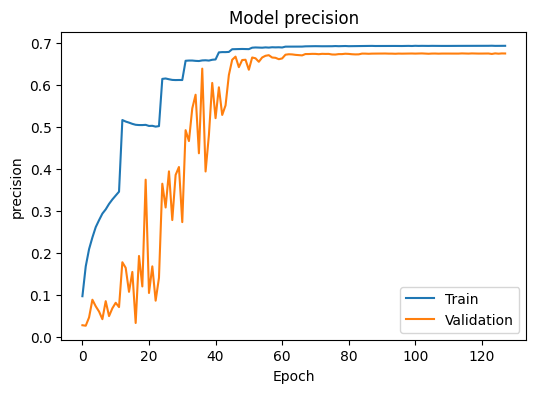

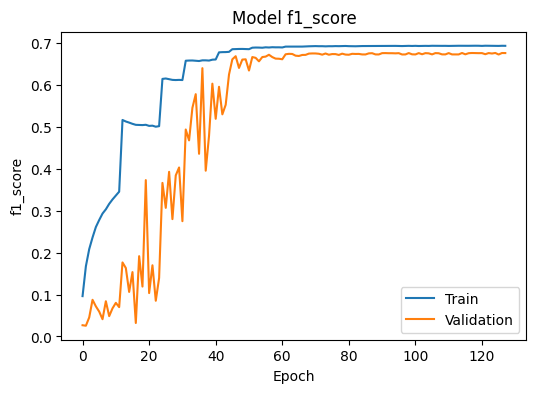

In [25]:
metrics = list(history_3.history.keys())

for metric in metrics:
    if metric.startswith('val')==False and metric!='lr':
        plt.figure(figsize=(6, 4))
        plt.plot(history_3.history[metric])
        plt.plot(history_3.history['val_'+metric])
        plt.title('Model '+metric)
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        if metric.endswith('loss'):
            plt.legend(['Train', 'Validation'], loc='upper right')
        else:
            plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

# **ResNet50**

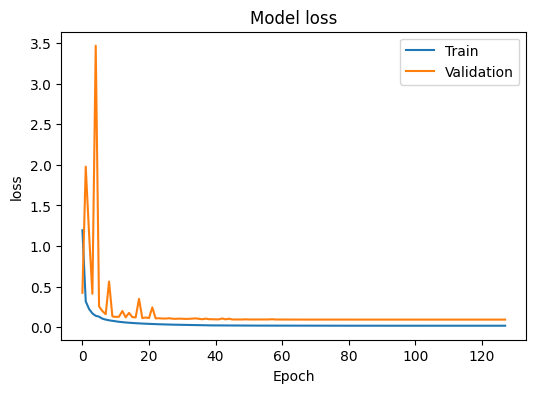

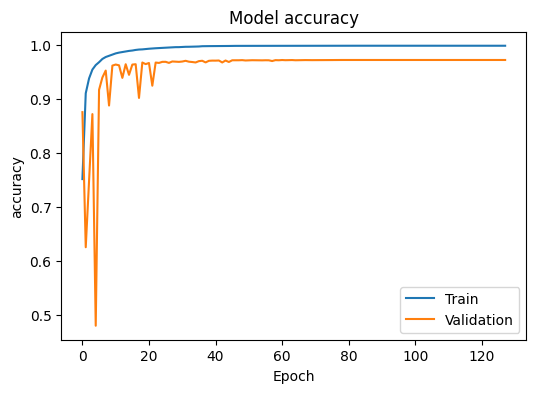

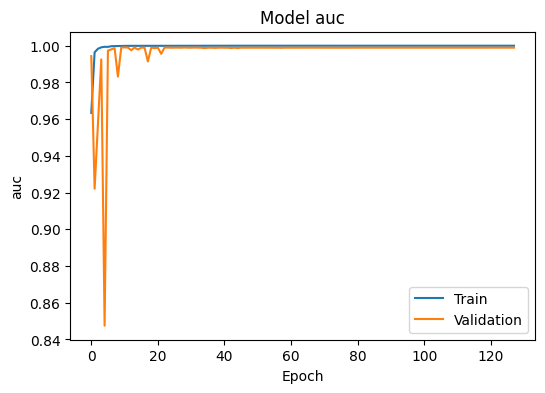

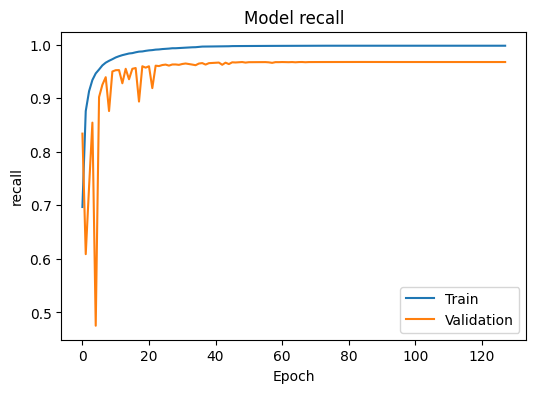

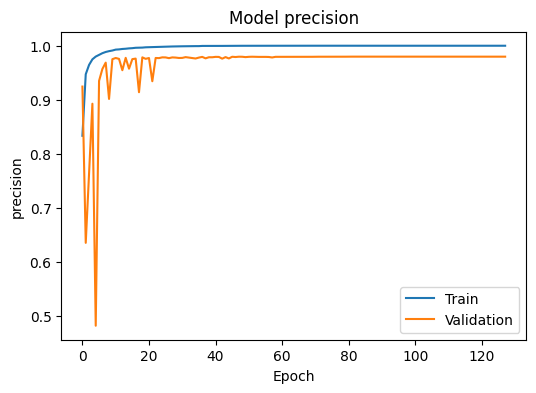

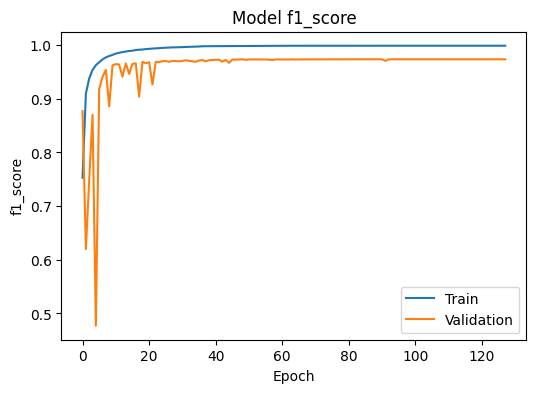

In [26]:
metrics = list(history_4.history.keys())

for metric in metrics:
    if metric.startswith('val')==False and metric!='lr':
        plt.figure(figsize=(6, 4))
        plt.plot(history_4.history[metric])
        plt.plot(history_4.history['val_'+metric])
        plt.title('Model '+metric)
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        if metric.endswith('loss'):
            plt.legend(['Train', 'Validation'], loc='upper right')
        else:
            plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

# **Xception**

In [ ]:
# metrics = list(history_5.history.keys())

# for metric in metrics:
#     if metric.startswith('val')==False and metric!='lr':
#         plt.figure(figsize=(6, 4))
#         plt.plot(history_5.history[metric])
#         plt.plot(history_5.history['val_'+metric])
#         plt.title('Model '+metric)
#         plt.ylabel(metric)
#         plt.xlabel('Epoch')
#         if metric.endswith('loss'):
#             plt.legend(['Train', 'Validation'], loc='upper right')
#         else:
#             plt.legend(['Train', 'Validation'], loc='lower right')

# plt.show()

# **MobileNetV2**

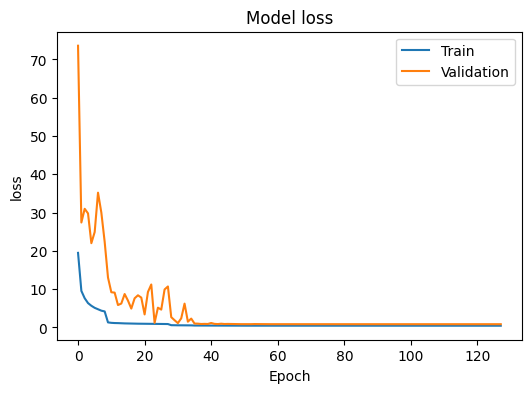

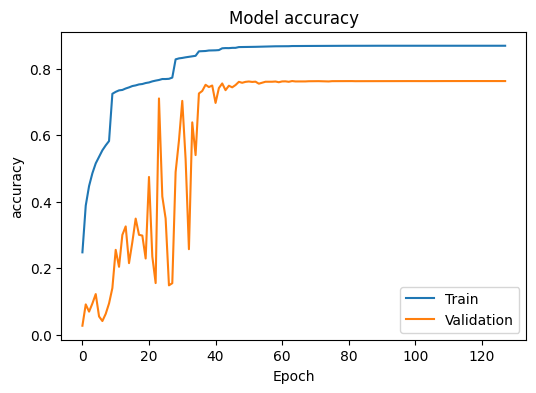

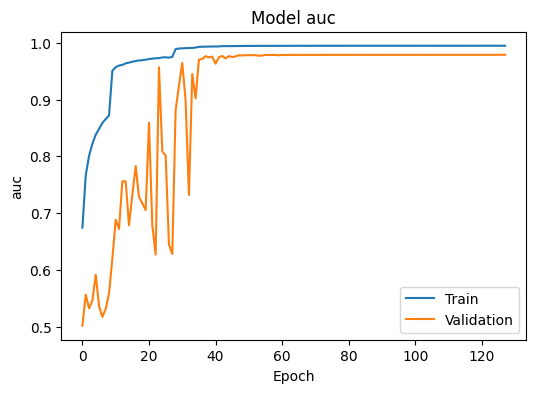

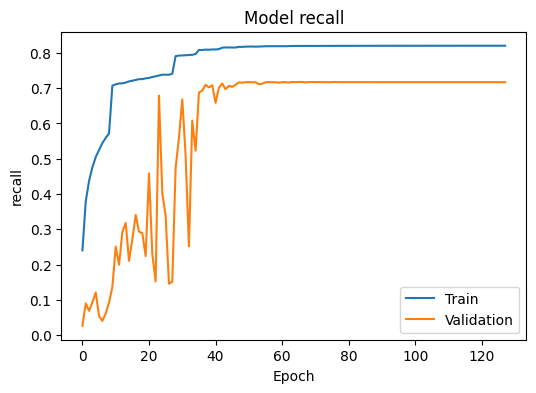

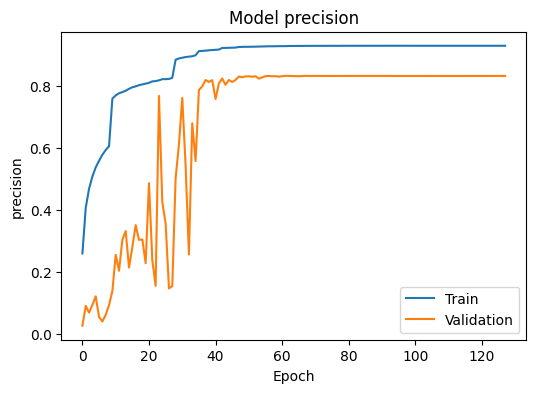

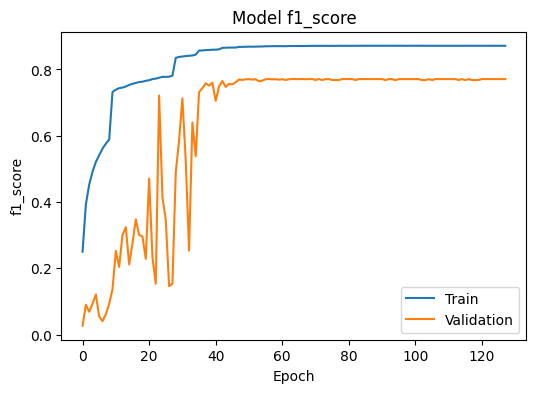

In [17]:
metrics = list(history_6.history.keys())

for metric in metrics:
    if metric.startswith('val')==False and metric!='lr':
        plt.figure(figsize=(6, 4))
        plt.plot(history_6.history[metric])
        plt.plot(history_6.history['val_'+metric])
        plt.title('Model '+metric)
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        if metric.endswith('loss'):
            plt.legend(['Train', 'Validation'], loc='upper right')
        else:
            plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()